<a href="https://colab.research.google.com/github/gunni95/KVP10k/blob/main/LayoutLMv3_kvp10k_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sitering for å bruke Modellen

```
@inproceedings{huang2022layoutlmv3,
  author={Yupan Huang and Tengchao Lv and Lei Cui and Yutong Lu and Furu Wei},
  title={LayoutLMv3: Pre-training for Document AI with Unified Text and Image Masking},
  booktitle={Proceedings of the 30th ACM International Conference on Multimedia},
  year={2022}
}
```

In [ ]:
import os              #navigere mapper og filer, hente filbaner
from PIL import Image  #åpne, vise og manipulere bilder
import json            #lese/skrive til JSON-filer


#Installer nødvendige biblioteker
!pip install -q Pillow
!pip install -q transformers datasets torch torchvision

ERROR: Operation cancelled by user
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/664.8 MB 14.7 MB/s eta 0:00:31ERROR: Operation cancelled by user
   ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.8/664.8 MB 13.8 MB/s eta 0:00:33


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/DAT255/KVP10k-dataset/train"
print(os.listdir(base_path))

['ocrs', 'gts', 'images', 'items']


# LayoutLMv3 - Hva skal jeg bruke?

- Steg 1. Må utføre Entity Extraction (EE).

- Steg 2. Utføre Relation Exctraction (RE). Formaliser RE som et matrise-problem, hvor man for alle par av entiteter **predikerer** om en relasjon finnes.
  - Relasjoner kan representeres som en N x N matrise over entitets-paret (i, j).

- Bruk en enkelt treningspipeline.

- Bruke **LayoutLMv3Processor** for å kombinere bilde, tekst, og bboxes, for å lage den input modellen krever.

- Bruke **LayoutLMv3ForTokenClassification** som modell for per-token tagging (EE).
  - Denne brukes for Entity tagging.
  - UTVID MED --> Ekstra kode for "*span grouping*" og "*entity embedding*".

_____

Steg 1:
  - Tagge tokens med (O, B-KEY, B-VALUE, I-KEY, I-VALUE), og derretter koble KEY --> VALUE.

Label-mappinger:


```
label2id = {
    "O": 0,
    "B-KEY": 1,
    "I-KEY": 2,
    "B-VALUE": 3,
    "I-VALUE": 4,
}
```



Steg 2:
LayoutLMv3Model er grunnlag for RE.
For å bruke denne modellen som egentlig er PyTorch native, må vi installere *transformers* og bruke PyTorch-backend.
UTVID med --> Egen relasjonsklassifisering mellom *key* og *value* spans
  - Kobling mellom key og value:
    1. Hente predikerte spans fra EE
    2. Lage relasjonsprediksjonsmodell RE

*Hentet fra:* https://arxiv.org/html/2404.10848v1


# Oppsummert

- Bruke LayoutLMv3Processor for å kombinere bilde, tokens, og bounding boxes (bboxes).

- Bruke LayoutLMv3ForTokenClassification til å tagge tokens som B-KEY, B-VALYE, O, etc.


1. Må utvide LayoutLMv3Model til å hente embeddings.
2. Implementere RE ved å sammenligne KVPs.
3. Evaluer RE med F1/Precision/Recall per relasjon.

#PyTorch (+ Hugging Face)
LayoutLMv3 er en del av *transformers*-biblioteket til Hugging Face.
Dette betyr at enten så må hele pipelinen utvikles i PyTorch, eller utvikle bare EE i PyTorch og få KEY-VALUE-Spans, så brukes TensorFlow for resten.

- Siden jeg er generelt usikker på begge bibliotekene så får vi se hva som blir valgt etterhvert...


# Dataset - forståelse

**Innhold i train/-mappen i KVP10k:**
_____
  - *images*/ --> .png bilder av hvert dokument. Visuell input for modellen.
    - Det modellen "ser".
_____

  - *ocrs*/ --> JSON-filer med **words** og **bboxes** for hvert dokument. Gir tekst og posisjoner fra OCR, og brukes sammen med images.
    - Det modellen "leser" (tokens og posisjonene deres).

_____

  - *gts*/ --> JSON-filer med KVPs og tilhørende bboxes. Inneholder hvilke keys og values som hører sammen.
    - Det som lærer modellen hvilke tokens som er nøkler, verdier, og hvilket som er koblet sammen.
_____

  - *items*/ --> JSON-filer med annotasjoner og layout-objs (rektangler, linker, etiketter)
    - tilleggsinformasjon
    - ikke viktig i for EE
    - Helt nødvendig i RE-delen av dette prosjektet
_____

# STEG 1 - Entity Exctraction

Preprosesser et datapunkt.
Lese inn:
  - OCR-data (tekst + bbox)
  - Ground Truth (gts, key/value + bbox)
  - Dokumentbilde (.png)


**Det brukes BIO-tagger, og dette er hva det står for:**
 - B --> Begin: første token i en entitet.
 - I --> Inside: inne i en entitet.
 - O --> Outside: tokenen er ikke en del av noen entitet

f.eks.
  - Tokens:  ["Name", "of", "buyer", ":", "Ole", "Martin", "Lystadmoen"]
  - Labels:  ["B-KEY", "I-KEY", "I-KEY", "O", "B-VALUE", "I-VALUE", "I-VALUE"]

In [ ]:
from transformers import LayoutLMv3Processor
import torch

processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False) # <-- Viktig fordi vi allerede har utført OCR på bildet og har tekst og bboxes

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
# Mapping fra tekstlige BIO-labels til tall som modellen bruker
label_map = {
    "O": 0,
    "B-KEY": 1,
    "I-KEY": 2,
    "B-VALUE": 3,
    "I-VALUE": 4,
}

# Funksjon for å skalere bounding boxes til 0-1000 (som LayoutLMv3 krever)
def normalize_bbox(bbox, width, height):
  return [
      int(1000 * (bbox[0] /width)),
      int(1000 * (bbox[1] / height)),
      int(1000 * (bbox[2] / width)),
      int(1000 * (bbox[3] / height))
  ]


def assign_label_for_box(box, boxes, label_type):
  """Returnerer liste med (index, label) for tokens som overlapper box"""
  overlaps = []
  for i, token_box in enumerate(boxes):
    if box_overlap(box, token_box) > 0:
      overlaps.append(i)

  overlaps = sorted(overlaps)

  labeled = []
  for j, idx in enumerate(overlaps):
    tag = f"B-{label_type}" if j == 0 else f"I-{label_type}"
    labeled.append((idx, tag))

  return labeled


 #Sjekker om OCR-boksen overlapper med GTS(key/value)-boksen.
#Ved overlapp hører de til hverandre.
def box_overlap(box1, box2):
  x0 = max(box1[0], box2[0])
  y0 = max(box1[1], box2[1])
  x1 = min(box1[2], box2[2])
  y1 = min(box1[3], box2[3])
  return max(0, x1 - x0) * max(0, y1 - y0)


# Funksjon for å generere BIO-labels fra gts (ground truth).
# Lager en BIO-label for hvert token basert på om det overlapper med en key- eller value-boks fra GTS.
# Matcher hvert token fra OCR (word + bbox) mot key/value-bbokser fra gts:
# --> Token overlapper en nøkkelboks: B-KEY eller I-KEY
# --> Token overlapper en verdiboks: B-VALUE eller I-VALUE
# --> Ellers: O
def iob_from_kvps(words, boxes, kvps):
  labels = ["O"] * len(words)

  #Gå igjennom alle key-value-pairs
  for kvp in kvps:
    if "key" in kvp and "bbox" in kvp["key"]:
      key_bbox = kvp["key"]["bbox"]
      for idx, tag in assign_label_for_box(key_bbox, boxes, "KEY"):
        labels[idx] = tag

    if "value" in kvp and "bbox" in kvp["value"]:
      value_box = kvp["value"]["bbox"]
      for idx, tag in assign_label_for_box(value_box, boxes, "VALUE"):
        labels[idx] = tag

  return labels

In [ ]:
def load_example(doc_id, base_path):
  image_path = os.path.join(base_path, "images", f"{doc_id}.png")
  ocr_path = os.path.join(base_path, "ocrs", f"{doc_id}.json")
  gt_path = os.path.join(base_path, "gts", f"{doc_id}.json")

  image = Image.open(image_path).convert("RGB")

  with open(ocr_path, "r", encoding="utf-8") as f:
    ocr_data = json.load(f)

  with open(gt_path, "r", encoding="utf-8") as f:
    gt_data = json.load(f)

  page = ocr_data["pages"][0]
  width, height = page["width"], page["height"]

  words = [w["text"] for w in page["words"]]
  raw_boxes = [w["bbox"] for w in page["words"]]
  boxes = [normalize_bbox(b, width, height) for b in raw_boxes]

  kvps = gt_data["kvps_list"]
  string_labels = iob_from_kvps(words, raw_boxes, kvps)
  labels = [label_map[l] for l in string_labels]

  #Fyller på med padding, og truncation klipper av hvis sekvensen har for mange tokens, returnerer som PyTorch-tensor
  encoding = processor(image, words, boxes=boxes, word_labels=labels, padding="max_length", truncation=True, return_tensors="pt")

  return encoding, words, boxes, string_labels

In [ ]:
doc_id = "aaf8db8517856054da0210f56f97e0acb910ca9a96be8d295050b3c9990ff8ed" #Eksempel dok. fra KVP10k
encoding, words, boxes, tags = load_example(doc_id, base_path)

print(encoding.keys())

#for w, t in zip(words, tags):
 # print(f"{w}: {t}")

dict_keys(['input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values'])


Grunnen til at det er så mye "O"-tagger er fordi det typisk i slike dokument-annotasjonsdatasett så er andelen tokens som er relevant (KEY/VAL) ofte kun 5-15% av ALLE tokens.

## Hva er gjort så langt?

- Lest inn images, ocrs, gts
- Laget BIO-tagger
- Verifisert at tokens for korrekte tagger
- En fungerende load_example()


## Neste blir å lage et Dataset-objekt for trening

In [ ]:
def get_doc_ids(base_path):
  return [filename.replace(".json", "") for filename in os.listdir(os.path.join(base_path, "ocrs"))]

In [ ]:
from torch.utils.data import Dataset

class KVP10kDataset(Dataset):
  def __init__(self, base_path, doc_ids):
    self.base_path = base_path
    self.doc_ids = doc_ids
    self.valid_doc_ids = []

    for doc_id in self.doc_ids:
      try:
        load_example(doc_id, base_path)
        self.valid_doc_ids.append(doc_id)
      except Exception as e:
        print(f"Feil i {doc_id}: {e}")

  def __len__(self):
    return len(self.doc_ids)

  def __getitem__(self, idx):
    doc_id = self.valid_doc_ids[idx]
    encoding, _, _ , _ = load_example(doc_id, self.base_path)

    return {
          "input_ids": encoding["input_ids"].squeeze(0),
          "attention_mask": encoding["attention_mask"].squeeze(0),
          "bbox": encoding["bbox"].squeeze(0),
          "labels": encoding["labels"].squeeze(0),
          "pixel_values": encoding["pixel_values"].squeeze(0)

    }


In [ ]:
doc_ids = get_doc_ids(base_path)[:1]
dataset = KVP10kDataset(base_path, doc_ids)

print("Antall gyldig dokumenter:", len(dataset))

sample = dataset[0]
print(sample.keys())

#Bruk denne nå preprosesserings koden er bevist å være helt korrekt og produserer data slik det ønskes
#torch.save(dataset, "/content/drive/MyDrive/kvp10k_tensor_dataset.pt")

Antall gyldig dokumenter: 1
dict_keys(['input_ids', 'attention_mask', 'bbox', 'labels', 'pixel_values'])


# Dataloader
**Når man jobber i Colab:**
 - CPU    --> num_workers = 2-4
 - T4 GPU --> num_workers = 2 + pin_memory = True
 - A100   --> num_workers = 4-8
____
*num_workers:*
- Antall parallelle prosesser som laster data i bakgrunn.
- Hvor mange CPU-kjerner som brukes.

*pin_memory:*
- Data lastes i pinned RAM --> raskere overføring til GPU.
- Når man bruker GPU.

*persistent_workers:*
- Holder dataarbeidere i live mellom epoker --> reduserer oppstartskostnader.
- kombineres med *num_workers* > 0

In [ ]:
def collate_fn(batch):
  batch = [b for b in batch if b is not None]
  if len(batch) == 0:
    return None

  return {
      key: torch.stack([b[key] for b in batch]) for key in batch[0]
  }

In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader (
    dataset,
    batch_size = 4,
    shuffle = True,
    collate_fn = collate_fn, # Brukes kun her for sikkerhet slik at om modellen ikke skal feile under trening, selv om vi allerede har en sjekk i Dataset-klassen
    num_workers = 2,
    pin_memory = True,
    persistent_workers = True
)

# Klargjør modellen

In [ ]:
from transformers import LayoutLMv3ForTokenClassification

id2label = {
    0: "O",
    1: "B-KEY",
    2: "I-KEY",
    3: "B-VALUE",
    4: "I-VALUE",
}

label2id = {
    "O": 0,
    "B-KEY": 1,
    "I-KEY": 2,
    "B-VALUE": 3,
    "I-VALUE": 4,
}

model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels = len(id2label),
    id2label = id2label,
    label2id = label2id,
)

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch = next(iter(dataloader))

for k, v in batch.items():
  print(f"{k}: {v.shape}")

input_ids: torch.Size([1, 512])
attention_mask: torch.Size([1, 512])
bbox: torch.Size([1, 512, 4])
labels: torch.Size([1, 512])
pixel_values: torch.Size([1, 3, 224, 224])


Bruke GPU

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

batch = {k: v.to(device) for k, v in batch.items()}

In [ ]:
outputs = model(**batch)
loss = outputs.loss
logits = outputs.logits

print(f"Loss: {loss}")
print(f"Logits: {logits.shape}")

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loss: 1.781430721282959
Logits: torch.Size([1, 512, 5])


Logits[4, 512, 5] forteller oss:
- 4 --> Batch size
- 512 --> maks sekvenslengde (tokens per dok.)
- 5 --> antall labels fra BIO (O, B-VALUE, B-KEY, B-KEY, I-KEY)

In [ ]:
#model.save_pretrained("/content/drive/MyDrive/layoutlmv3_kvp10k_model")
#processor.save_pretrained("/content/drive/MyDrive/layoutlmv3_kvp10k_model")

# Validere

In [ ]:
from sklearn.model_selection import train_test_split

doc_ids = get_doc_ids(base_path)[:500] #Juster denne

train_ids, temp_ids = train_test_split(doc_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)


print(f"Train: {len(train_ids)}")
print(f"Val: {len(val_ids)}")
print(f"Test: {len(test_ids)}")

train_dataset = KVP10kDataset(base_path, train_ids)
val_dataset = KVP10kDataset(base_path, val_ids)
test_dataset = KVP10kDataset(base_path, test_ids)

Train: 350
Val: 75
Test: 75


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size = 4,
    shuffle = True,
    collate_fn = collate_fn,
    num_workers = 0,
    pin_memory = True,
    persistent_workers = False
)

val_loader = DataLoader(
    val_dataset,
    batch_size = 4,
    shuffle = False,
    collate_fn = collate_fn,
    num_workers = 0,
    pin_memory = True,
    persistent_workers = False
)

test_loader = DataLoader(
    test_dataset,
    batch_size = 4,
    shuffle = False,
    collate_fn = collate_fn,
    num_workers = 0,
    pin_memory = True,
    persistent_workers = False
)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def evaluate(model, dataloader, device, id2label):
  model.eval()
  true_labels = []
  pred_labels = []

  with torch.no_grad():
    for batch in dataloader:
      if batch is None:
        continue

      batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1)

      for true, pred, mask in zip(batch["labels"], predictions, batch["attention_mask"]):
        #Fjern padding tokens
        true = true[mask.bool()].cpu().numpy()
        pred = pred[mask.bool()].cpu().numpy()

        # Fjern -100 siden vi bruker sklearn (som ikke vet at -100 brukes for å ignorere subtokens som ikke skal evalueres)
        filtered_true = [t for t in true if t != -100]
        filtered_pred = [p for (t, p) in zip(true, pred) if t != -100]

        true_labels.extend(filtered_true)
        pred_labels.extend(filtered_pred)


  precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="macro")
  accuracy = np.mean(np.array(true_labels) == np.array(pred_labels))

  model.train()
  return precision, recall, f1, accuracy

In [ ]:
import torch
from torch.optim import AdamW
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5) # 5e-5 er standard for Hugging Face-modeller

In [ ]:
def train_loop(model, train_loader, val_loader, optimizer, device, id2label, num_epochs=3, patience=3):
  model.train()
  best_f1 = 0
  epochs_no_improve = 0

  for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", disable=True)

    for batch in progress_bar:
      if batch is None:
        continue

      batch = {k: v.to(device) for k, v in batch.items()}
      optimizer.zero_grad() #Nullstiller gradienter fra forrige batch
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()

      total_loss += loss.item()
      progress_bar.set_postfix({"loss": loss.item()})

    average_loss = total_loss / len(train_loader)

    print(f"\n Epoch {epoch+1} ferdig - loss: {average_loss:.4f}")

    train_prec, train_rec, train_f1, train_acc = evaluate(model, train_loader, device, id2label)
    val_prec, val_rec, val_f1, val_acc = evaluate(model, val_loader, device, id2label)

    print(f"\n TRAIN: --> precision({train_prec:.4f}), recall({train_rec:.4f}), f1({train_f1:.4f}), accuracy({train_acc:.4f}) \n")
    print(f"\n VAL: ----> precision({val_prec:.4f}), recall({val_rec:.4f}), f1({val_f1:.4f}), accuracy({val_acc:.4f}) \n")


    #Early stopping
    if val_f1 > best_f1:
      best_f1 = val_f1
      epochs_no_improve = 0

      #model.save_pretrained("/content/drive/MyDrive/layoutlmv3_kvp10k_model")
      #processor.save_pretrained("/content/drive/MyDrive/layoutlmv3_kvp10k_model")
    else:
      epochs_no_improve += 1

    if epochs_no_improve >= patience:
      print(f"Early stopping etter {epoch+1} epoch")
      print(f"Modell lagret med beste F1. Epoch: {epoch+1}")
      break

In [ ]:
train_loop(model, train_loader, val_loader, optimizer, device, id2label, num_epochs=10, patience=3)


 Epoch 1 ferdig - loss: 0.7037

 TRAIN: --> precision(0.8711), recall(0.6619), f1(0.7286), accuracy(0.8437) 


 VAL: ----> precision(0.8664), recall(0.6848), f1(0.7519), accuracy(0.8714) 


 Epoch 2 ferdig - loss: 0.4688

 TRAIN: --> precision(0.8062), recall(0.8414), f1(0.8202), accuracy(0.8738) 


 VAL: ----> precision(0.7514), recall(0.8077), f1(0.7749), accuracy(0.8605) 


 Epoch 3 ferdig - loss: 0.3787

 TRAIN: --> precision(0.8381), recall(0.8782), f1(0.8551), accuracy(0.8968) 


 VAL: ----> precision(0.7830), recall(0.8322), f1(0.8016), accuracy(0.8702) 


 Epoch 4 ferdig - loss: 0.3081

 TRAIN: --> precision(0.8812), recall(0.9170), f1(0.8983), accuracy(0.9308) 


 VAL: ----> precision(0.7915), recall(0.8388), f1(0.8133), accuracy(0.8883) 


 Epoch 5 ferdig - loss: 0.2237

 TRAIN: --> precision(0.8480), recall(0.9401), f1(0.8869), accuracy(0.9090) 


 VAL: ----> precision(0.7380), recall(0.8631), f1(0.7850), accuracy(0.8455) 


 Epoch 6 ferdig - loss: 0.1758

 TRAIN: --> preci

In [ ]:
evaluate(model, test_loader, device, id2label)

(0.8268966734485064,
 0.8181994667065519,
 0.8222005522409022,
 np.float64(0.9112253403723256))

In [ ]:
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


In [ ]:
def load_model_input(doc_id, base_path):
    encoding, _, _, _ = load_example(doc_id, base_path)
    return encoding


In [ ]:
def load_visualization_data(doc_id, base_path):
    encoding, words, boxes, string_labels = load_example(doc_id, base_path)

    image_path = os.path.join(base_path, "images", f"{doc_id}.png")
    image = Image.open(image_path).convert("RGB")

    return image, words, boxes, string_labels


In [ ]:
def draw_predicted_labels_on_document(doc_id, base_path, labels_to_draw, label_colors, title_prefix="Modellens prediksjon", fontsize=12):
    from PIL import ImageDraw, ImageFont
    import matplotlib.pyplot as plt

    image, words, boxes, _ = load_visualization_data(doc_id, base_path)
    width, height = image.size
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 12)
    except:
        font = ImageFont.load_default()

    for word, bbox, label in zip(words, boxes, labels_to_draw):
        box = unnormalize_box(bbox, width, height)
        color = label_colors.get(label, "red")
        draw.rectangle(box, outline=color, width=2)
        draw.text((box[0] + 5, box[1] - 10), label, fill=color, font=font)

    color_legend = ", ".join(f"{farge}={etikett}" for etikett, farge in label_colors.items())
    plt.figure(figsize=(12, 14))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"{title_prefix}: {doc_id}\nFarger: {color_legend}", fontsize=fontsize)
    plt.show()


In [ ]:
def draw_labels_on_image(doc_id, base_path, labels, label_colors, title_prefix="Tittel"):
    from PIL import ImageDraw, ImageFont
    import matplotlib.pyplot as plt

    image, words, boxes, _ = load_visualization_data(doc_id, base_path)
    width, height = image.size
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 12)
    except:
        font = ImageFont.load_default()

    for word, bbox, label in zip(words, boxes, labels):
        box = unnormalize_box(bbox, width, height)
        color = label_colors.get(label, "red")
        draw.rectangle(box, outline=color, width=2)
        draw.text((box[0] + 5, box[1] - 10), label, fill=color, font=font)

    plt.figure(figsize=(12, 14))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"{title_prefix}: {doc_id}")
    plt.show()


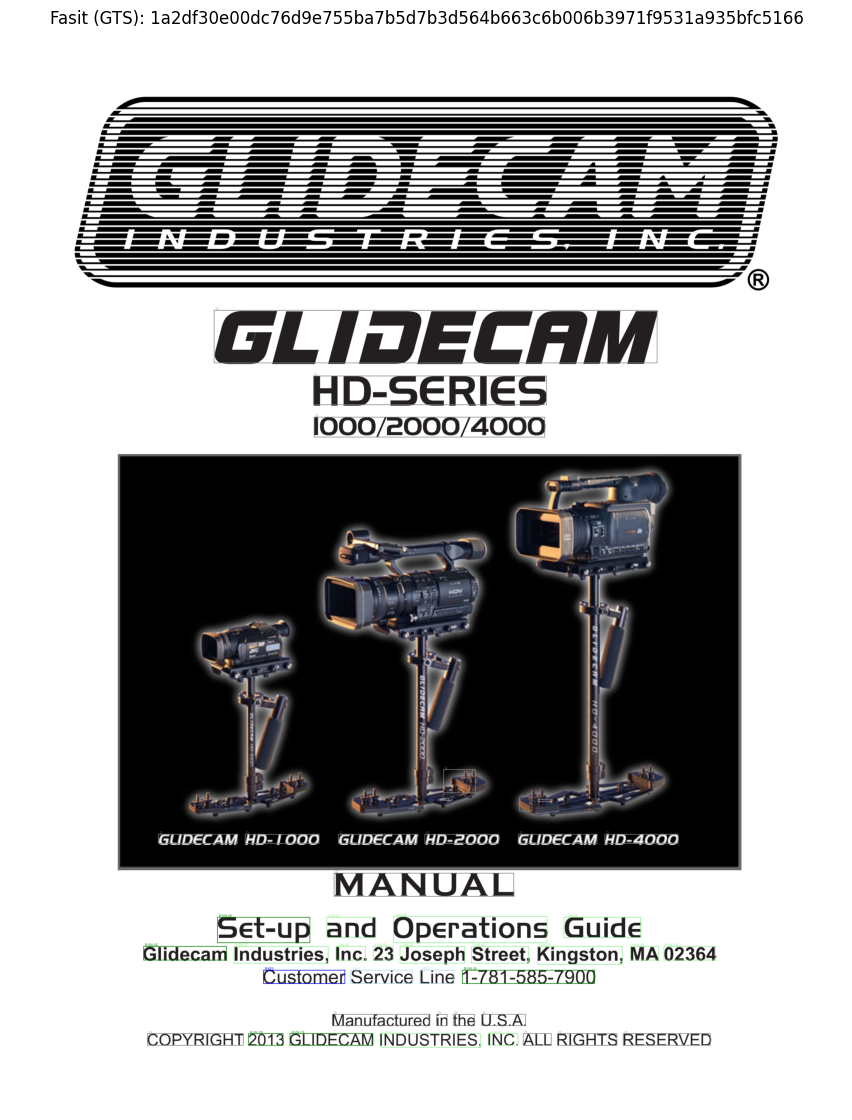

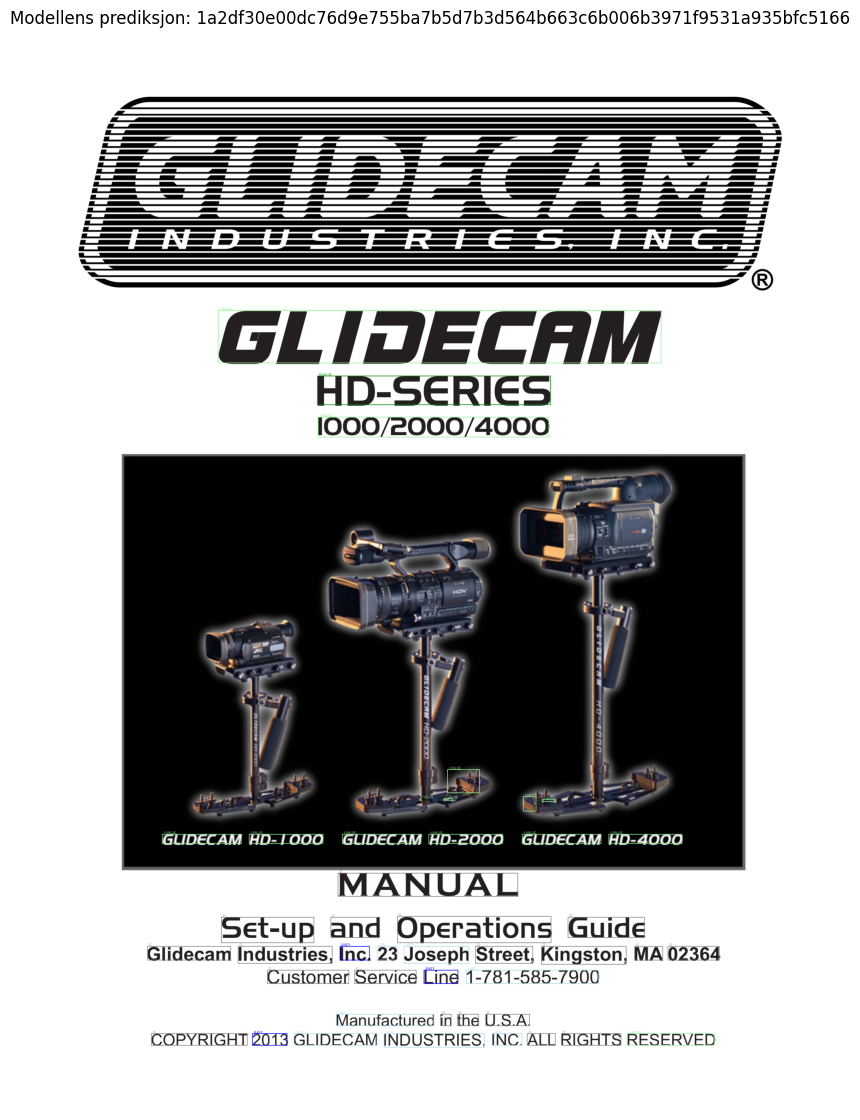

In [ ]:
import torch

# === Velg dokument-id og lag dataset med kun det ===
doc_id = get_doc_ids(base_path)[-1]
dataset = KVP10kDataset(base_path, [doc_id])
sample = dataset[0]

# === Modellinput ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_ids = sample["input_ids"].unsqueeze(0).to(device)
attention_mask = sample["attention_mask"].unsqueeze(0).to(device)
bbox = sample["bbox"].unsqueeze(0).to(device)
pixel_values = sample["pixel_values"].unsqueeze(0).to(device)

# === Modellkjøring ===
model.eval()
model.to(device)
with torch.no_grad():
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        bbox=bbox,
        pixel_values=pixel_values
    )

# === Prediksjoner ===
logits = outputs.logits
pred_ids = torch.argmax(logits, dim=-1).squeeze(0).cpu().tolist()

# === BIO-mapping ===
reverse_label_map = {v: k for k, v in label_map.items()}
predicted_labels = [reverse_label_map[i] for i in pred_ids]

# === Hent ord og bokser for visualisering ===
_, words, _, true_labels = load_example(doc_id, base_path)
predicted_labels = predicted_labels[:len(words)]  # Match lengde

# === BIO-fargekart ===
label_colors = {
    "B-KEY": "blue",
    "I-KEY": "lightblue",
    "B-VALUE": "green",
    "I-VALUE": "lightgreen",
    "O": "grey"
}

# === Visualiser FASIT ===
draw_labels_on_image(doc_id, base_path, true_labels, label_colors, title_prefix="Fasit (GTS)")

# === Visualiser MODELL ===
draw_labels_on_image(doc_id, base_path, predicted_labels, label_colors, title_prefix="Modellens prediksjon")


In [ ]:
# --- Notebook B ---

import torch
import torch.nn as nn

# 1. Definer relasjonslaget
class RelationExtractionHead(nn.Module):
    def __init__(self, hidden_size, num_relations):
        super().__init__()
        self.head_proj = nn.Linear(hidden_size, hidden_size)
        self.tail_proj = nn.Linear(hidden_size, hidden_size)
        self.bilinear = nn.Bilinear(hidden_size, hidden_size, num_relations)

    def forward(self, hidden_states):
        batch_size, seq_len, hidden_dim = hidden_states.size()
        head = self.head_proj(hidden_states)
        tail = self.tail_proj(hidden_states)

        relations = torch.zeros(batch_size, seq_len, seq_len, self.bilinear.out_features).to(hidden_states.device)
        for i in range(seq_len):
            for j in range(seq_len):
                relations[:, i, j, :] = self.bilinear(head[:, i, :], tail[:, j, :])
        return relations  # (batch, seq_len, seq_len, num_relations)

# 2. Last inn hidden states
# Alternativ 1: nedlastet fil
# hidden_states = torch.load("hidden_states.pt")

# Alternativ 2: fra Google Drive
from google.colab import drive
drive.mount('/content/drive')
hidden_states = torch.load("/content/drive/MyDrive/hidden_states.pt")

# 3. Initier og kjør relasjonsmodellen
relation_head = RelationExtractionHead(hidden_size=768, num_relations=5)  # justér etter behov
relation_head.eval()

with torch.no_grad():
    relation_logits = relation_head(hidden_states)  # (batch, seq_len, seq_len, num_relations)
    predicted_relations = relation_logits.argmax(dim=-1)

# 4. Eksempel: print relasjoner mellom tokens
batch_idx = 0
relations = predicted_relations[batch_idx]  # (seq_len, seq_len)

print("Relasjoner (i -> j):")
seq_len = relations.size(0)
for i in range(seq_len):
    for j in range(seq_len):
        label = relations[i][j].item()
        if label != 0:  # 0 = no_relation
            print(f"Token {i} -> Token {j} = Relation {label}")
